### Expedia Hotel Ranking

##### Problem statement
Each record of the dataset is an item in the search results and contains both search-level features (the input of the user, his country/city etc) and item-level features (information about the hotel). For each search in this dataset we observe which item was chosen at the end of the session.

Given these features, try and learn a model for hotel relevance.

##### Evaluation
Evaluation Metric is NDCG@50. Relevance is given by propbookingbool
(https://en.wikipedia.org/wiki/Discounted_cumulative_gain#Normalized_DCG)

##### Data fields
srch_id: unique identifier for a search <br/>
visitor_id: visitor id used to submit the search <br/>
visitor_visit_nbr: count of visits for the user who has submitted the search <br/>
visitor_loc_country: country of the user who has submitted the search <br/>
visitor_loc_region: region of the user who has submitted the search <br/>
visitor_loc_city: city of the user who has submitted the search <br/>
visitor_wr_member: indicates if user is part of the hcom loyalty program<br/>
posa_continent: point of sale continent for a partiular search<br/>
posa_country: point of sale country for a particular search<br/>
srch_hcom_destination_id: destination id for a particular search <br/>
srch_dest_longitude: destination center longitude for a particular search<br/>
srch_dest_latitude: destination center latitude for a particular search<br/>
srch_ci: date of check-in of a search<br/>
srch_co: date of cehck-in of a search<br/>
srch_ci_day: day of check-in of a search<br/>
srch_co_day: day of check-out of a search<br/>
srch_los: length of stay of a search (check-in - check-out date)<br/>
srch_bw: booking window of a search (search-date - check-in date)<br/>
srch_adults_cnt: number of adults for a search <br/>
srch_children_cnt: number of children for a search <br/>
srch_rm_cnt: number of requested rooms on the search <br/>
mobile_bool: indicates if the search was submitted on a mobile browser<br/>
mobile_app: indicates if the search was submitted on a mobile app<br/>
device: identifies the device type type used for this search<br/>
currency: currency relevant for the point of sale the search was submitted form<br/>
position: the rank this property has been impressed on in a particular search<br/>
travelad_bool: indicates if a porperty in a search was a paid advert<br/>
dotd_bool: indicates if a property in a search was advertised as a special "daily deal"<br/>
price_without_discount_local: discounted property price in local (posa specific) currency<br/>
price_without_discount_usd: discounted property price in USD<br/>
price_with_discount_local: non-discounted property price in local currency<br/>
price_with_discount_usd: non-discounted property price in USD<br/>
imp_drr: name of the pricing/discount rule relevant for this property<br/>
click_bool: indicates if a property has been clicked in a particular search<br/>
booking_bool: indicates if property has been booken in a given search<br/>
prop_key: unique property identifier<br/>
prop_brand_bool: indicates if a property has a popular brand<br/>
prop_starrating: conventional hotel star rating (1-5 Stars)<br/>
prop_super_region: the super region this property belongs to (EMEA, APAC, NA, LATAM)<br/>
prop_continent: continent this property is located on (EU, NA, ...)<br/>
prop_country: country this property is located in<br/>
prop_market_id: higher granularity geo classification<br/>
prop_submarket_id: highest granularity geo classification<br/>
prop_room_capacity: max number of rooms this property has available<br/>
prop_review_score: average guest review score for this property<br/>
prop_review_count: count of customer reviews for this property<br/>
prop_hostel_bool: indicates if a property is a hostel<br/>
local_date: date for a particular search<br/>

### Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import seaborn as sns
%load_ext autoreload
%autoreload 2
%matplotlib inline

from dataprep.dataprep import DataPrep
from rank.ranker import Ranker
from pipeline.pipeline import Pipeline

##### Get data

In [2]:
test_data = pd.read_csv(r'C:\Users\afragkoulis\PyCharmProjects\sortranking\data\test.csv')
#, keep_default_na=False, na_values=[ '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', 
#     '1.#IND', '1.#QNAN', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'])
train_data = pd.read_csv(r'C:\Users\afragkoulis\PyCharmProjects\sortranking\data\train.csv')

##### Exploratory analysis

In [3]:
train_data.iloc[:,:].head()

,srch_id,prop_key,srch_date_time,srch_visitor_id,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,...,prop_super_region,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date
0,-1046322713,3873959,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,80,4.7,43.0,0,2014-09-13
1,-1046322713,3214020,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98222,334,3.6,254.0,0,2014-09-13
2,-1046322713,3066218,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,339,3.6,101.0,0,2014-09-13
3,-1046322713,3942297,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,98278,10,0.0,0.0,1,2014-09-13
4,-1046322713,2271987,2014-09-13 18:37:32,9373b009-4e10-495a-afae-204dd1fe4b7c,5,TWN,TPE,TAIPEI,Signed in - Persistent|WR Member|Remembered FC...,ASIA,...,APAC,ASIA,JAPAN,60041,109140,179,4.1,1189.0,0,2014-09-13


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831742 entries, 0 to 831741
Data columns (total 47 columns):
srch_id                              831742 non-null int64
prop_key                             831742 non-null int64
srch_date_time                       831742 non-null object
srch_visitor_id                      831742 non-null object
srch_visitor_visit_nbr               831742 non-null int64
srch_visitor_loc_country             831742 non-null object
srch_visitor_loc_region              831562 non-null object
srch_visitor_loc_city                831742 non-null object
srch_visitor_wr_member               394313 non-null object
srch_posa_continent                  354021 non-null object
srch_posa_country                    831742 non-null object
srch_hcom_destination_id             831742 non-null int64
srch_dest_longitude                  831742 non-null float64
srch_dest_latitude                   831742 non-null float64
srch_ci                              831742 non-nul

In [5]:
train_data.iloc[:,20:].describe()

,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_mobile_bool,srch_mobile_app,prop_travelad_bool,prop_dotd_bool,prop_price_without_discount_local,prop_price_without_discount_usd,prop_price_with_discount_local,...,prop_imp_drr,prop_booking_bool,prop_brand_bool,prop_starrating,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool
count,831732.000000,831732.000000,831742.000000,831742.000000,831742.0,831742.000000,831742.000000,8.316960e+05,8.316960e+05,8.316960e+05,...,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831742.000000,831732.000000,831732.000000,831742.000000
mean,2.027230,0.161410,1.116735,0.145973,0.0,0.012150,0.003903,1.224948e+04,4.388639e+02,8.575644e+03,...,0.425870,0.028585,0.662960,3.589997,71708.060714,106500.747586,629.401151,4.020631,2164.589189,0.002896
std,1.075608,0.552974,0.470007,0.353080,0.0,0.109557,0.062349,1.704853e+05,6.075591e+03,1.126003e+05,...,0.494475,0.166636,0.472699,0.866611,39069.697032,7370.403186,1580.685335,0.549570,3083.087088,0.053740
min,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,8.000000e+00,0.000000e+00,5.000000e+00,...,0.000000,0.000000,0.000000,0.000000,369.000000,60556.000000,-9998.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,1.690000e+02,1.421800e+02,1.150000e+02,...,0.000000,0.000000,0.000000,3.000000,60039.000000,98238.000000,143.000000,3.800000,304.000000,0.000000
50%,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,3.390000e+02,2.700000e+02,2.340000e+02,...,0.000000,0.000000,1.000000,4.000000,95602.000000,109153.000000,305.000000,4.100000,935.000000,0.000000
75%,2.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,6.640000e+02,4.483300e+02,4.660000e+02,...,1.000000,0.000000,1.000000,4.000000,95656.000000,110287.000000,770.000000,4.400000,2556.000000,0.000000
max,20.000000,23.000000,8.000000,1.000000,0.0,1.000000,1.000000,3.195489e+07,1.976733e+06,1.230545e+07,...,1.000000,1.000000,1.000000,5.000000,116356.000000,116928.000000,19235.000000,5.000000,32399.000000,1.000000


In [6]:
numerical_cols = ['prop_key', 'srch_visitor_visit_nbr', 'srch_los', 'srch_bw', 'srch_adults_cnt', 'srch_children_cnt',
                 'srch_rm_cnt', 'srch_ci_day', 'srch_co_day', 'srch_mobile_bool', 'prop_travelad_bool', 'prop_dotd_bool', 
                  'prop_price_with_discount_local', 'prop_price_with_discount_usd','prop_imp_drr', 'prop_booking_bool', 
                  'prop_brand_bool', 'prop_starrating', 'prop_market_id', 'prop_submarket_id', 'prop_room_capacity', 
                  'prop_review_score', 'prop_review_count', 'prop_hostel_bool']
categorical_cols = ['srch_visitor_loc_country', 'srch_visitor_loc_region', 'srch_visitor_loc_city', 
                    'srch_visitor_wr_member', 'srch_posa_continent', 'srch_posa_country', 'srch_device', 'srch_currency',
                   'prop_super_region', 'prop_continent', 'prop_country']
datetime_cols = ['srch_date_time', 'srch_ci', 'srch_co', 'srch_local_date']

• Drop `srch_visitor_id` unique identifier <br/>
• Drop `srch_mobile_app` all 0s
• Fill `posa_continent` nulls here are just 'NA' being parsed as null on data import <br/>
• `visitor_wr_member` are nulls essentially users not signed up? <br/>
• Convert `date_time`, `ci`, `co` to datetime object <br/>
• Potentially high multicolinearity in currency/POSa/location fields, price fields, `srch_hcom_destination_id` and `prop_market_id`and mob/app indicators? <br/>
• Split `visitor_wr_member` in more cols
• Predict: `prop_booking_bool` <br/>
 <br/>
Fills: <br/>
• `srch_currency` (fill mode of POSa, categorical)<br/>
• `srch_visitor_loc_region` (fill from city backwards - make dict) <br/>
• `srch_visitor_loc_city` (fill mode for country - I think region data may be too sparse in ~800k rows) <br/>
• `srch_adults_cnt` (fill mode, int) <br/>
• [dropped]`prop_price_without_discount_local` (fill with mean for specific POSa/POSu vector)<br/>
• [dropped]`prop_price_without_discount_usd` (fill with mean for specific POSa/POSu vector)<br/>
• `prop_price_with_discount_local` (fill with mean for specific POSa/POSu vector) <br/>
• `prop_price_with_discount_usd` (fill with mean for specific POSa/POSu vector) <br/>
• `prop_review_score` (fill mode ok here I think, super low missing values) <br/>
• `prop_review_count` (fill mode ok here I think, super low missing values) <br/>

In [8]:
corr = train_data.corr()
cors = corr.abs().unstack().sort_values(ascending=False)
cors[29:45]

srch_id                            srch_id                              1.000000
prop_price_with_discount_local     prop_price_without_discount_local    0.923643
prop_price_without_discount_local  prop_price_with_discount_local       0.923643
prop_market_id                     srch_hcom_destination_id             0.902099
srch_hcom_destination_id           prop_market_id                       0.902099
prop_price_without_discount_usd    prop_price_with_discount_usd         0.886548
prop_price_with_discount_usd       prop_price_without_discount_usd      0.886548
srch_dest_longitude                srch_hcom_destination_id             0.792570
srch_hcom_destination_id           srch_dest_longitude                  0.792570
prop_market_id                     srch_dest_latitude                   0.764237
srch_dest_latitude                 prop_market_id                       0.764237
srch_adults_cnt                    srch_rm_cnt                          0.710629
srch_rm_cnt                 

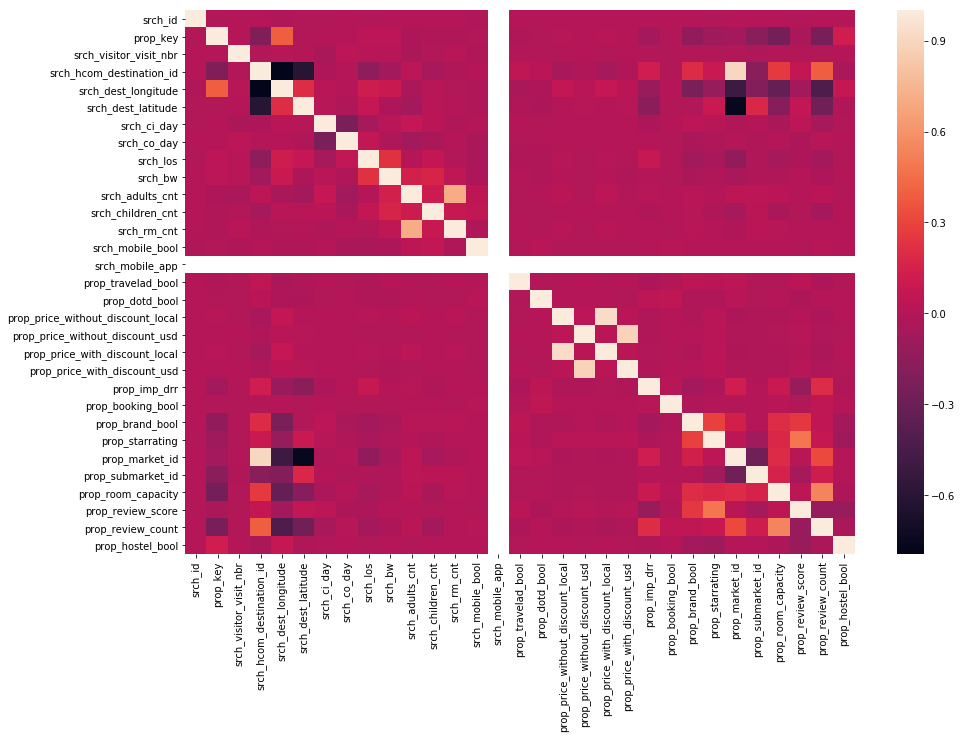

In [9]:
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, ax=ax)

Ok first pass try dropping both non-discounted prices(I guess these aren't the prices customers get to see?).

Also, drop long/lat since highly corr with both `srch_hcom_destination_id` and `prop_market_id`.

Lastly, drop 1 of `srch_hcom_destination_id` and `prop_market_id`.

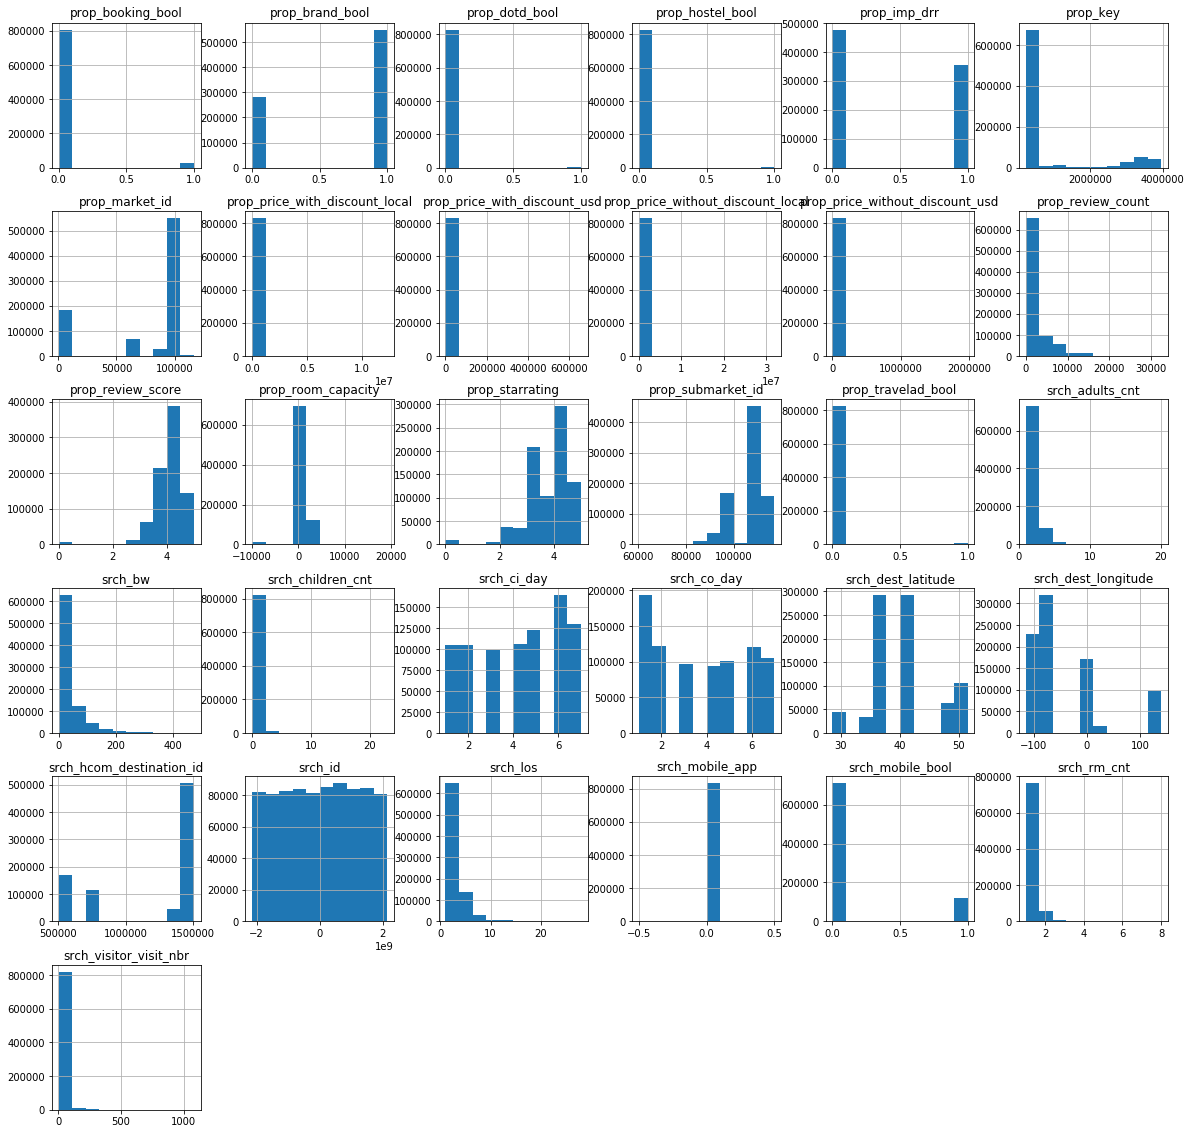

In [10]:
hist = train_data.hist(figsize=(20,20))

Clean `prop_price_with_discount_local`, `prop_price_with_discount_usd`, `prop_room_capacity` some prices too high and can't have negative room capacity. Maybe drop top percentile in `srch_visitor_visit_nbr` bots?

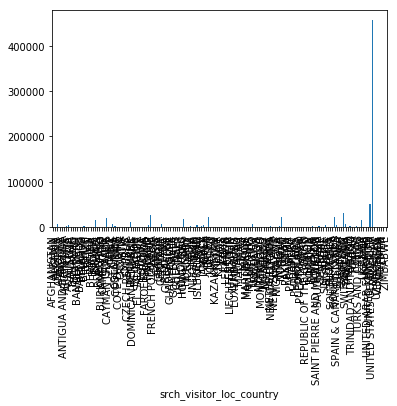

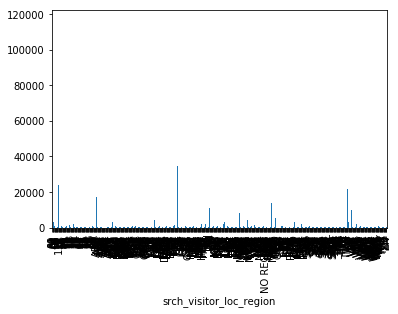

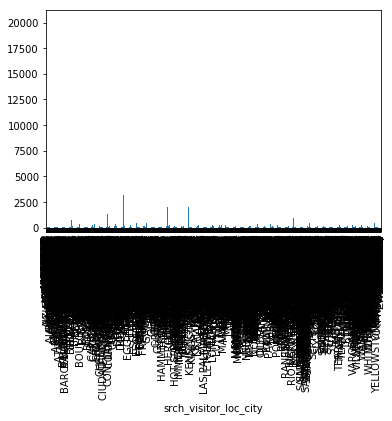

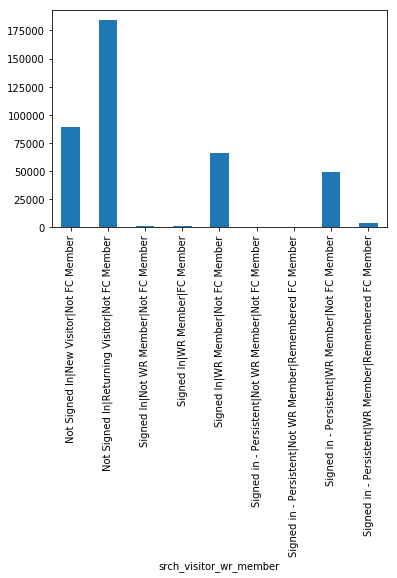

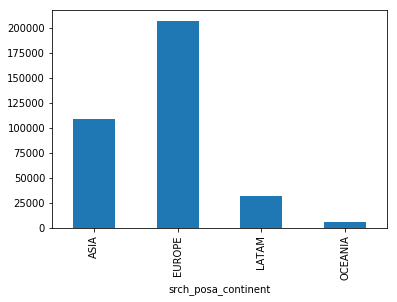

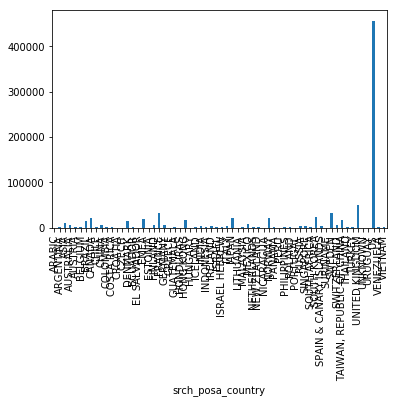

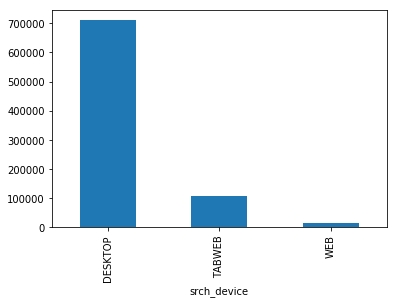

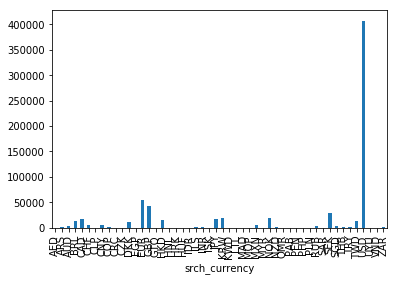

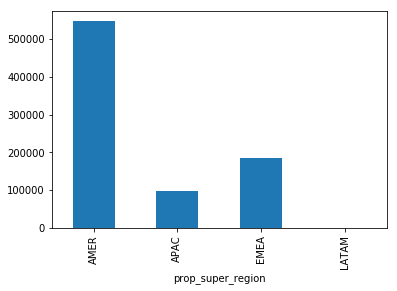

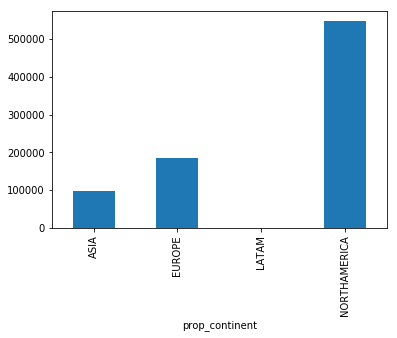

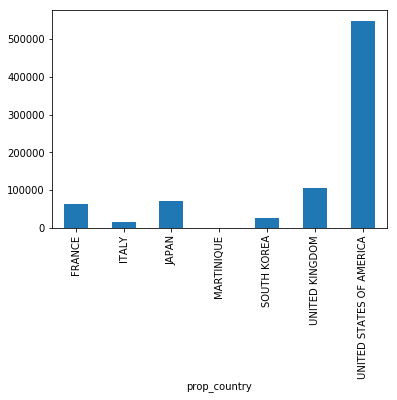

In [11]:
for i, col in enumerate(categorical_cols):
    plt.figure()
    train_data[[col]].groupby(col).size().plot(kind='bar')

In [12]:
for col in categorical_cols:
    print(col, len(train_data[col].unique()))

srch_visitor_loc_country 151
srch_visitor_loc_region 584
srch_visitor_loc_city 5067
srch_visitor_wr_member 10
srch_posa_continent 5
srch_posa_country 64
srch_device 3
srch_currency 51
prop_super_region 4
prop_continent 4
prop_country 7


do something about high cardinality features? some PCA maybe? 

In [13]:
# sns.pairplot(train_data)

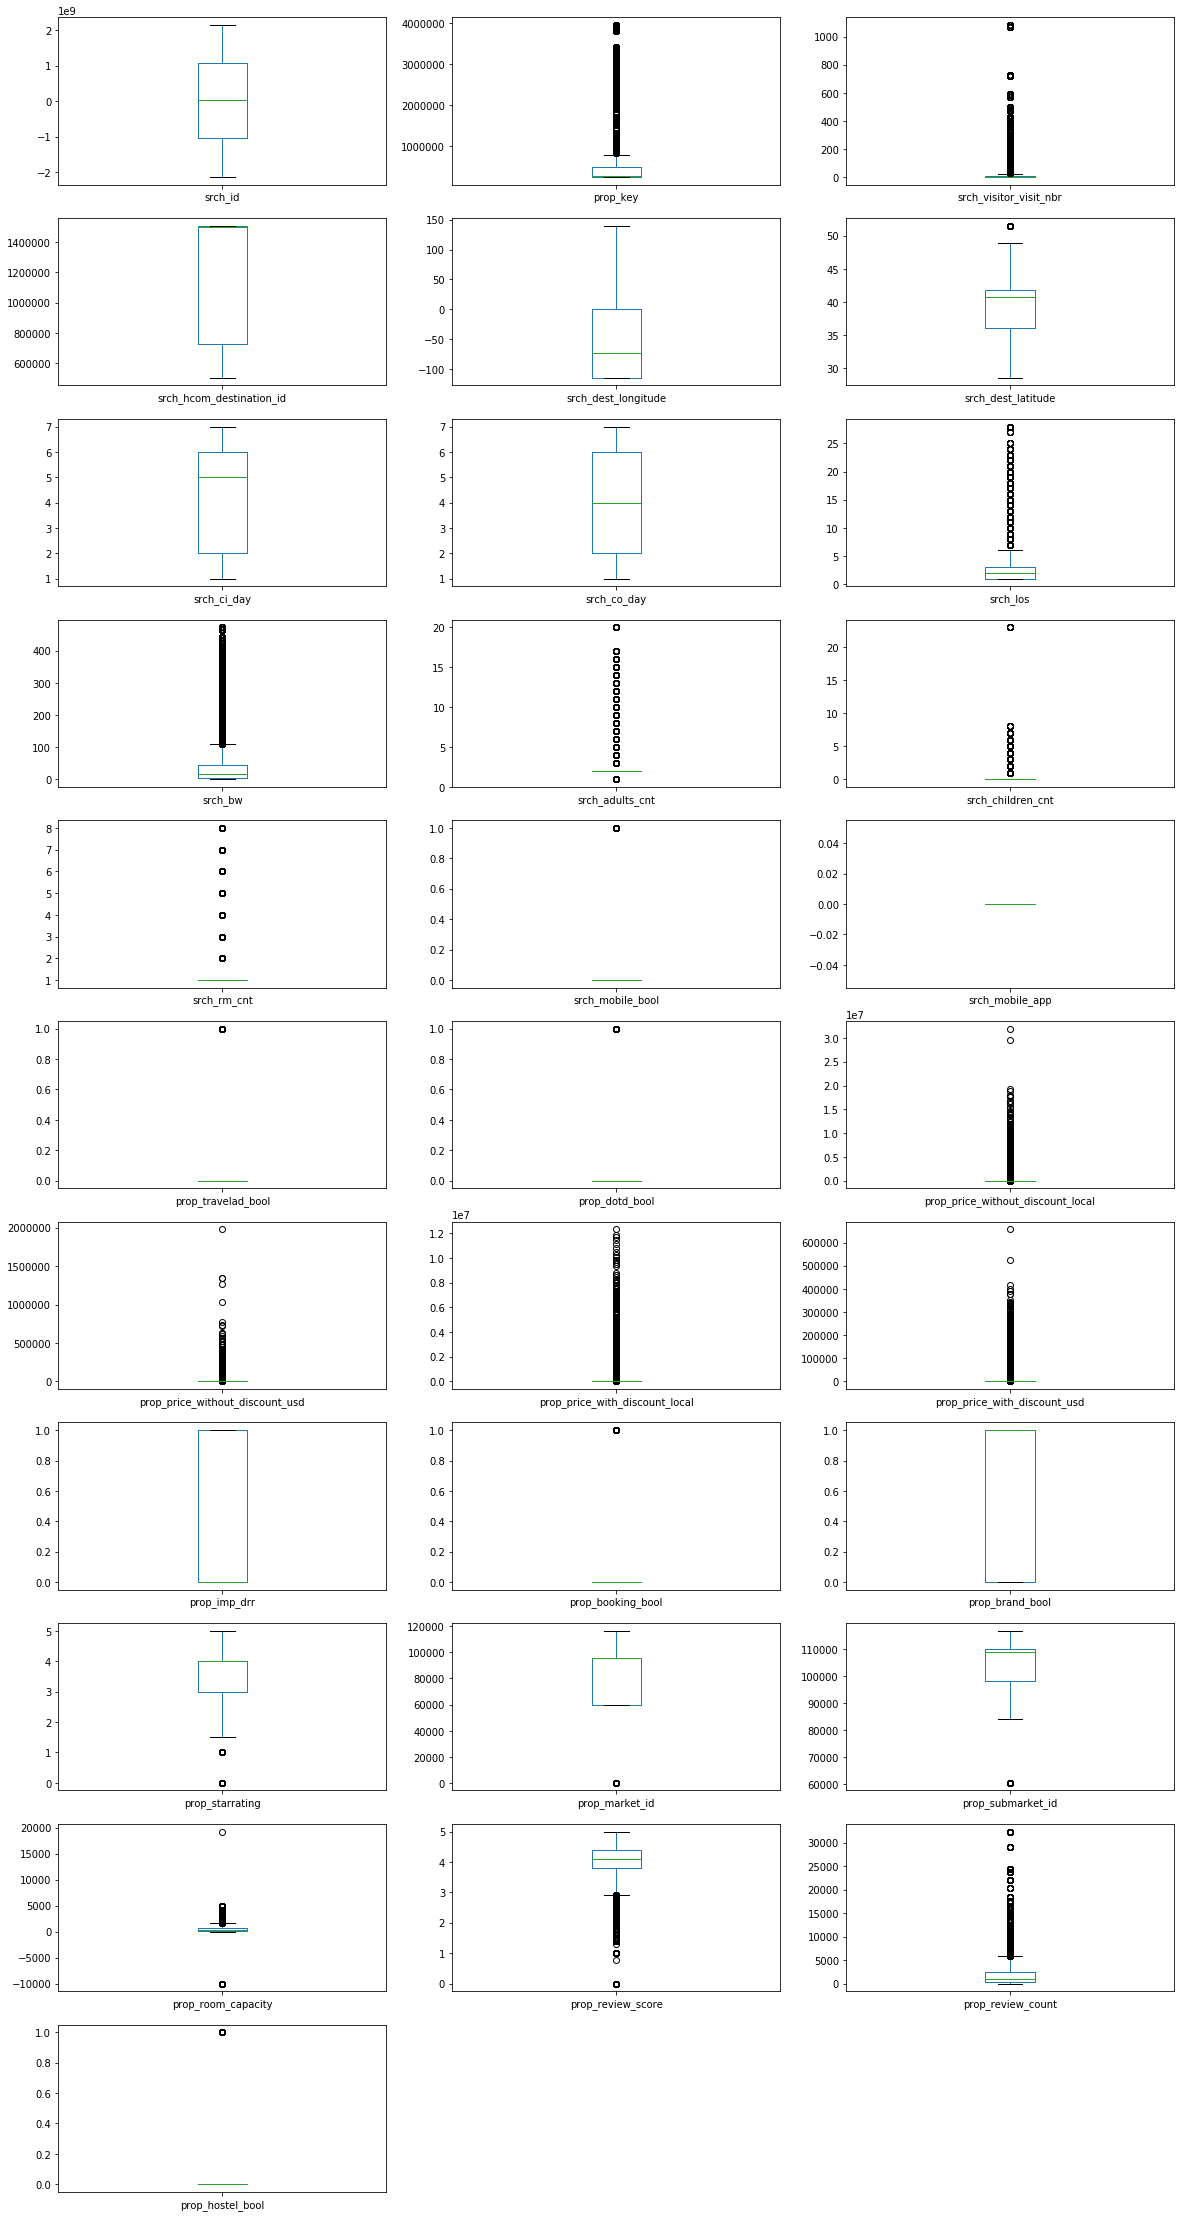

In [14]:
train_data.plot(kind='box', subplots=True, layout=(11,3), sharex=False, sharey=False, figsize = (20,40)); 
plt.show();

##### Feature engineering

In [ ]:
# split all datetime cols
# property specific CTR rate (times booked / times shown in results)
# 

##### Configs

In [108]:
raw_train_data = train_data.reset_index().copy()
raw_test_data = test_data.reset_index().copy()

In [109]:
train_dataprep = DataPrep(raw_train_data)
test_dataprep = DataPrep(raw_test_data)
df_train = train_dataprep.return_df()
df_test = test_dataprep.return_df()

KeyError: 'srch_co'

In [ ]:
df_test.head()

In [ ]:
df_train.info()

In [92]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 353711 entries, -1000941564 to 99798130
Data columns (total 38 columns):
prop_key                          353711 non-null int64
srch_date_time                    353711 non-null float64
srch_visitor_visit_nbr            353711 non-null float64
srch_visitor_loc_country          353711 non-null float64
srch_visitor_loc_region           353711 non-null float64
srch_visitor_loc_city             353711 non-null float64
srch_visitor_wr_member            353711 non-null float64
srch_posa_continent               353711 non-null float64
srch_posa_country                 353711 non-null float64
srch_ci                           353711 non-null float64
srch_co                           353711 non-null float64
srch_ci_day                       353711 non-null float64
srch_co_day                       353711 non-null float64
srch_los                          353711 non-null float64
srch_bw                           353711 non-null float64
srch_adul

##### Ranker - Normalised DCG (Discounted cumulative gain)
Two assumptions are made in using DCG and its related measures.

Highly relevant documents are more useful when appearing earlier in a search engine result list (have higher ranks)
Highly relevant documents are more useful than marginally relevant documents, which are in turn more useful than non-relevant documents.

<img src='img\nDCG.png'>
where IDCG is ideal discounted cumulative gain,
<img src='img\IDCG.png'>

##### Model training

In [93]:
# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Cross-val
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score

# Processing
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel

In [94]:
from sklearn.model_selection import train_test_split
def split_data(df):
    X = df.drop('prop_booking_bool', axis=1).copy()
    y = df['prop_booking_bool'].copy()
    return train_test_split(X, y, test_size=0.2, random_state=1337)
X_train, X_test, y_train, y_test = split_data(df_train)

# K Best Selection
# k_best_selector = SelectKBest()
# X_train = k_best_selector.fit_transform(X_train, y_train)
# X_test = k_best_selector.transform(X_test)

In [95]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_train_pred = prediction_function(model, X_train)
#     scoring = ['average_precision', 'recall']
#     kfold = KFold(n_splits=10, random_state=1337)
#     for scoring in scoring:
#         cv_results = cross_val_score(model, X_test, y_test, cv=kfold, scoring=scoring)
#         print("%f (%f)" % (cv_results.mean(), cv_results.std()))
    print('*'*20 + 'TRAIN' + '*'*20)
    print('train precision: %.2f' % (precision_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))))
    print('train recall: %.2f' % (recall_score(y_train, y_train_pred, average='weighted', labels=np.unique(y_train_pred))))
    print('train avg precision: %.2f' % (average_precision_score(y_train, y_train_pred, average='weighted')))
#     print('train accuracy: %.2f%%' % (100*accuracy_score(y_train, y_train_pred)))
    print('*'*20 + 'TEST' + '*'*20)
    y_test_pred = prediction_function(model, X_test)
    print('test precision: %.2f' % (precision_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))))
    print('test recall: %.2f' % (recall_score(y_test, y_test_pred, average='weighted', labels=np.unique(y_test_pred))))
    print('train avg precision: %.2f' % (average_precision_score(y_train, y_train_pred, average='weighted')))
#     print('test accuracy: %.2f%%' % (100*accuracy_score(y_test, y_test_pred)))    
    return model

##### Pointwise ranking

In [96]:
#LR
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]
lr_model = train_model(LogisticRegression(solver='lbfgs', max_iter=10000, random_state=1337), 
                    get_predicted_outcome, X_train, y_train, X_test, y_test)

********************TRAIN********************
train precision: 0.97
train recall: 1.00
train avg precision: 0.03
********************TEST********************
test precision: 0.97
test recall: 1.00
train avg precision: 0.03


In [ ]:
# XGBOOST
xgb_model = train_model(XGBClassifier(random_state=1337), get_predicted_outcome, X_train, y_train, X_test, y_test)

##### CatBoost on NDCG

In [97]:
from catboost import CatBoostClassifier
cat_model = train_model(CatBoostClassifier(loss_function='CrossEntropy'), get_predicted_outcome, X_train, y_train, X_test, y_test)

Learning rate set to 0.104852
0:	learn: 0.5327591	total: 338ms	remaining: 5m 37s
1:	learn: 0.4204380	total: 727ms	remaining: 6m 2s
2:	learn: 0.3393876	total: 1.14s	remaining: 6m 19s
3:	learn: 0.2825316	total: 1.48s	remaining: 6m 7s
4:	learn: 0.2420876	total: 1.87s	remaining: 6m 11s
5:	learn: 0.2123457	total: 2.25s	remaining: 6m 12s
6:	learn: 0.1907151	total: 2.62s	remaining: 6m 12s
7:	learn: 0.1752392	total: 3s	remaining: 6m 11s
8:	learn: 0.1635824	total: 3.35s	remaining: 6m 9s
9:	learn: 0.1548027	total: 3.7s	remaining: 6m 6s
10:	learn: 0.1481376	total: 4.05s	remaining: 6m 4s
11:	learn: 0.1430395	total: 4.47s	remaining: 6m 8s
12:	learn: 0.1390383	total: 4.9s	remaining: 6m 11s
13:	learn: 0.1361941	total: 5.33s	remaining: 6m 15s
14:	learn: 0.1339573	total: 5.72s	remaining: 6m 15s
15:	learn: 0.1321496	total: 6.1s	remaining: 6m 15s
16:	learn: 0.1308169	total: 6.54s	remaining: 6m 18s
17:	learn: 0.1295137	total: 6.91s	remaining: 6m 16s
18:	learn: 0.1286180	total: 7.32s	remaining: 6m 17s
19:	

157:	learn: 0.1199372	total: 1m 7s	remaining: 5m 57s
158:	learn: 0.1199269	total: 1m 7s	remaining: 5m 56s
159:	learn: 0.1199076	total: 1m 7s	remaining: 5m 55s
160:	learn: 0.1198957	total: 1m 8s	remaining: 5m 54s
161:	learn: 0.1198868	total: 1m 8s	remaining: 5m 53s
162:	learn: 0.1198702	total: 1m 8s	remaining: 5m 53s
163:	learn: 0.1198480	total: 1m 9s	remaining: 5m 53s
164:	learn: 0.1198205	total: 1m 9s	remaining: 5m 52s
165:	learn: 0.1197993	total: 1m 10s	remaining: 5m 51s
166:	learn: 0.1197750	total: 1m 10s	remaining: 5m 50s
167:	learn: 0.1197671	total: 1m 10s	remaining: 5m 50s
168:	learn: 0.1197558	total: 1m 10s	remaining: 5m 49s
169:	learn: 0.1197348	total: 1m 11s	remaining: 5m 48s
170:	learn: 0.1197245	total: 1m 11s	remaining: 5m 47s
171:	learn: 0.1197137	total: 1m 11s	remaining: 5m 46s
172:	learn: 0.1196941	total: 1m 12s	remaining: 5m 45s
173:	learn: 0.1196817	total: 1m 12s	remaining: 5m 44s
174:	learn: 0.1196675	total: 1m 13s	remaining: 5m 44s
175:	learn: 0.1196483	total: 1m 13s	

310:	learn: 0.1179153	total: 2m 4s	remaining: 4m 36s
311:	learn: 0.1179113	total: 2m 5s	remaining: 4m 35s
312:	learn: 0.1178892	total: 2m 5s	remaining: 4m 35s
313:	learn: 0.1178807	total: 2m 5s	remaining: 4m 34s
314:	learn: 0.1178749	total: 2m 6s	remaining: 4m 34s
315:	learn: 0.1178549	total: 2m 6s	remaining: 4m 33s
316:	learn: 0.1178497	total: 2m 6s	remaining: 4m 33s
317:	learn: 0.1178392	total: 2m 7s	remaining: 4m 33s
318:	learn: 0.1178302	total: 2m 7s	remaining: 4m 32s
319:	learn: 0.1178242	total: 2m 8s	remaining: 4m 32s
320:	learn: 0.1178088	total: 2m 8s	remaining: 4m 32s
321:	learn: 0.1177944	total: 2m 9s	remaining: 4m 32s
322:	learn: 0.1177779	total: 2m 9s	remaining: 4m 31s
323:	learn: 0.1177717	total: 2m 10s	remaining: 4m 31s
324:	learn: 0.1177503	total: 2m 10s	remaining: 4m 30s
325:	learn: 0.1177437	total: 2m 10s	remaining: 4m 30s
326:	learn: 0.1177375	total: 2m 11s	remaining: 4m 29s
327:	learn: 0.1177292	total: 2m 11s	remaining: 4m 29s
328:	learn: 0.1177199	total: 2m 11s	remai

464:	learn: 0.1163193	total: 3m 6s	remaining: 3m 34s
465:	learn: 0.1163131	total: 3m 6s	remaining: 3m 34s
466:	learn: 0.1162897	total: 3m 7s	remaining: 3m 33s
467:	learn: 0.1162686	total: 3m 7s	remaining: 3m 33s
468:	learn: 0.1162595	total: 3m 8s	remaining: 3m 32s
469:	learn: 0.1162538	total: 3m 8s	remaining: 3m 32s
470:	learn: 0.1162483	total: 3m 8s	remaining: 3m 32s
471:	learn: 0.1162375	total: 3m 9s	remaining: 3m 31s
472:	learn: 0.1162322	total: 3m 9s	remaining: 3m 31s
473:	learn: 0.1162245	total: 3m 10s	remaining: 3m 31s
474:	learn: 0.1162196	total: 3m 10s	remaining: 3m 30s
475:	learn: 0.1162083	total: 3m 11s	remaining: 3m 30s
476:	learn: 0.1161967	total: 3m 11s	remaining: 3m 29s
477:	learn: 0.1161913	total: 3m 11s	remaining: 3m 29s
478:	learn: 0.1161860	total: 3m 12s	remaining: 3m 29s
479:	learn: 0.1161770	total: 3m 12s	remaining: 3m 28s
480:	learn: 0.1161678	total: 3m 12s	remaining: 3m 28s
481:	learn: 0.1161613	total: 3m 13s	remaining: 3m 27s
482:	learn: 0.1161512	total: 3m 13s	r

618:	learn: 0.1149570	total: 4m 11s	remaining: 2m 34s
619:	learn: 0.1149468	total: 4m 11s	remaining: 2m 34s
620:	learn: 0.1149396	total: 4m 12s	remaining: 2m 33s
621:	learn: 0.1149335	total: 4m 12s	remaining: 2m 33s
622:	learn: 0.1149265	total: 4m 12s	remaining: 2m 33s
623:	learn: 0.1149220	total: 4m 13s	remaining: 2m 32s
624:	learn: 0.1149159	total: 4m 13s	remaining: 2m 32s
625:	learn: 0.1149102	total: 4m 14s	remaining: 2m 31s
626:	learn: 0.1149069	total: 4m 14s	remaining: 2m 31s
627:	learn: 0.1148989	total: 4m 15s	remaining: 2m 31s
628:	learn: 0.1148918	total: 4m 15s	remaining: 2m 30s
629:	learn: 0.1148843	total: 4m 15s	remaining: 2m 30s
630:	learn: 0.1148732	total: 4m 16s	remaining: 2m 29s
631:	learn: 0.1148656	total: 4m 16s	remaining: 2m 29s
632:	learn: 0.1148606	total: 4m 17s	remaining: 2m 29s
633:	learn: 0.1148548	total: 4m 17s	remaining: 2m 28s
634:	learn: 0.1148497	total: 4m 17s	remaining: 2m 28s
635:	learn: 0.1148424	total: 4m 18s	remaining: 2m 27s
636:	learn: 0.1148342	total:

771:	learn: 0.1137117	total: 5m 12s	remaining: 1m 32s
772:	learn: 0.1137053	total: 5m 12s	remaining: 1m 31s
773:	learn: 0.1136979	total: 5m 13s	remaining: 1m 31s
774:	learn: 0.1136917	total: 5m 13s	remaining: 1m 31s
775:	learn: 0.1136880	total: 5m 13s	remaining: 1m 30s
776:	learn: 0.1136696	total: 5m 14s	remaining: 1m 30s
777:	learn: 0.1136649	total: 5m 14s	remaining: 1m 29s
778:	learn: 0.1136615	total: 5m 15s	remaining: 1m 29s
779:	learn: 0.1136455	total: 5m 15s	remaining: 1m 29s
780:	learn: 0.1136399	total: 5m 15s	remaining: 1m 28s
781:	learn: 0.1136349	total: 5m 16s	remaining: 1m 28s
782:	learn: 0.1136314	total: 5m 16s	remaining: 1m 27s
783:	learn: 0.1136279	total: 5m 17s	remaining: 1m 27s
784:	learn: 0.1136209	total: 5m 17s	remaining: 1m 26s
785:	learn: 0.1136166	total: 5m 17s	remaining: 1m 26s
786:	learn: 0.1136042	total: 5m 18s	remaining: 1m 26s
787:	learn: 0.1135939	total: 5m 18s	remaining: 1m 25s
788:	learn: 0.1135806	total: 5m 19s	remaining: 1m 25s
789:	learn: 0.1135746	total:

926:	learn: 0.1125863	total: 6m 12s	remaining: 29.3s
927:	learn: 0.1125788	total: 6m 12s	remaining: 28.9s
928:	learn: 0.1125688	total: 6m 13s	remaining: 28.5s
929:	learn: 0.1125626	total: 6m 13s	remaining: 28.1s
930:	learn: 0.1125542	total: 6m 14s	remaining: 27.7s
931:	learn: 0.1125500	total: 6m 14s	remaining: 27.3s
932:	learn: 0.1125446	total: 6m 14s	remaining: 26.9s
933:	learn: 0.1125422	total: 6m 15s	remaining: 26.5s
934:	learn: 0.1125355	total: 6m 15s	remaining: 26.1s
935:	learn: 0.1125307	total: 6m 15s	remaining: 25.7s
936:	learn: 0.1125207	total: 6m 16s	remaining: 25.3s
937:	learn: 0.1125159	total: 6m 16s	remaining: 24.9s
938:	learn: 0.1125103	total: 6m 17s	remaining: 24.5s
939:	learn: 0.1125032	total: 6m 17s	remaining: 24.1s
940:	learn: 0.1124966	total: 6m 17s	remaining: 23.7s
941:	learn: 0.1124867	total: 6m 18s	remaining: 23.3s
942:	learn: 0.1124800	total: 6m 18s	remaining: 22.9s
943:	learn: 0.1124713	total: 6m 18s	remaining: 22.5s
944:	learn: 0.1124626	total: 6m 19s	remaining:

##### ListNet

load dataset
The number of data, train: 521692 validate: 130423
prepare initialized model!
Start training and validation loop......
epoch 1


  0%|                                                                                         | 0/5217 [00:00<?, ?it/s]C:\Users\afragkoulis\PyCharmProjects\sortranking\rank\ListNet.py:56: RuntimeWarning: invalid value encountered in greater
  ind = vec_true.data * vec_compare.data > 0
100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:38<00:00, 135.51it/s]


train mean loss=18.043672978979934


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 396.65it/s]


test  mean loss=0.0
epoch: 2
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 2


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:40<00:00, 129.01it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 408.14it/s]


test  mean loss=0.0
epoch: 3
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 3


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:42<00:00, 122.71it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 405.15it/s]


test  mean loss=0.0
epoch: 4
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 4


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:37<00:00, 140.22it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:02<00:00, 437.47it/s]


test  mean loss=0.0
epoch: 5
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 5


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:37<00:00, 140.28it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 415.21it/s]


test  mean loss=0.0
epoch: 6
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 6


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:39<00:00, 133.48it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:02<00:00, 441.62it/s]


test  mean loss=0.0
epoch: 7
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 7


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:38<00:00, 134.00it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 398.35it/s]


test  mean loss=0.0
epoch: 8
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 8


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:37<00:00, 137.67it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 380.47it/s]


test  mean loss=0.0
epoch: 9
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 9


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:36<00:00, 141.36it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:02<00:00, 441.62it/s]


test  mean loss=0.0
epoch: 10
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
epoch 10


100%|█████████████████████████████████████████████████████████████████████████████| 5217/5217 [00:37<00:00, 137.98it/s]


train mean loss=0.0


100%|█████████████████████████████████████████████████████████████████████████████| 1305/1305 [00:03<00:00, 420.83it/s]


test  mean loss=0.0
epoch: 11
NDCG@100 | train: 0.016910281599645218, test: 0.015370132701064394
save the model
save the optimizer


array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

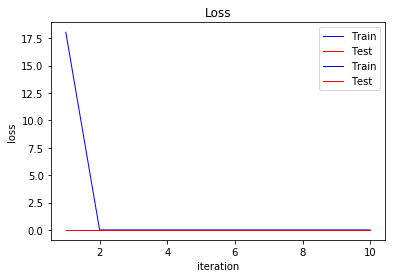

In [74]:
from rank import ListNet
list_model = ListNet.ListNet()
# train_model(list_model, get_predicted_outcome, X_train, y_train, X_test, y_test)
list_model.fit(X_train.values, y_train.values, batchsize=100, n_epoch=10, n_units1=512, n_units2=128, 
               tv_ratio=0.8, optimizerAlgorithm="Adam", savefigName="result.pdf", savemodelName="ListNet.model")

In [75]:
list_model.predict(X_test.values)

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]], dtype=float32)

##### LightGBM

### Submission
Suppose that in our test file we only have two searches:<br/>
• srchid 1234 with propkeys {546,678,678}<br/>
• srchid 2345 with propkeys {987,849,839,930}<br/>
<br/>
the your submission should look like:<br/>
srchid propkey<br/>
1234 546<br/>
1234 678<br/>
1234 890 <br/>
2345 930<br/>
2345 839<br/>
2345 987<br/>
2345 849<br/>
<br/>
ASC srchid, properties in DESC ranking order<br/>

In [98]:
final_df.head()

,prop_key,srch_date_time,srch_visitor_visit_nbr,srch_visitor_loc_country,srch_visitor_loc_region,srch_visitor_loc_city,srch_visitor_wr_member,srch_posa_continent,srch_posa_country,srch_ci,...,prop_continent,prop_country,prop_market_id,prop_submarket_id,prop_room_capacity,prop_review_score,prop_review_count,prop_hostel_bool,srch_local_date,purch_prob
srch_id,,,,,,,,,,,,,,,,,,,,,
-1000941564,248900,0.323649,-0.113494,0.579861,1.973705,1.665575,-0.452434,-0.964992,0.528625,-0.369100,...,-1.098255,0.106942,-1.828365,0.955105,-0.618091,-0.609185,-0.474021,-0.054278,0.259761,NaN
-1001968982,277020,-0.708666,-0.267271,0.609269,0.764656,0.348461,0.855457,0.768713,0.636566,-0.862768,...,0.682065,0.547289,0.605371,-1.326188,-0.310573,0.890981,-0.017781,-0.054278,-0.739500,NaN
-100230717,254542,-1.640784,-0.328781,0.609269,0.351810,-1.444399,0.855457,0.768713,0.636566,0.725553,...,0.682065,0.547289,0.605576,0.498492,0.241607,0.140898,0.522000,-0.054278,-1.613853,NaN
-100230717,474241,-1.640784,-0.328781,0.609269,0.351810,-1.444399,0.855457,0.768713,0.636566,0.725553,...,0.682065,0.547289,0.605576,0.391302,-0.584245,0.703460,-0.046276,-0.054278,-1.613853,NaN
-1004694318,3249295,1.450370,-0.082739,-1.361113,0.668817,-0.471982,-1.237169,-1.831844,-2.601650,2.528511,...,-1.988415,-1.654445,-0.304275,0.357166,-0.690619,-0.421664,-0.692588,-0.054278,1.508837,NaN


In [99]:
final_df = df_test.copy() 
# final_df['no_purch'] = lr_model.predict_proba(df_test)[:, 0:1]
final_df['purch_prob'] = cat_model.predict_proba(df_test)[:, 1:2]

In [100]:
final_df[['purch_prob', 'prop_key']].reset_index().head()

,srch_id,purch_prob,prop_key
0,-1000941564,0.048542,248900
1,-1001968982,0.111320,277020
2,-100230717,0.013627,254542
3,-100230717,0.023895,474241
4,-1004694318,0.020026,3249295


In [101]:
submission_df = final_df[['purch_prob', 'prop_key']].sort_values(by=['srch_id', 'purch_prob'], ascending=[False, False])\
.drop('purch_prob', axis=1)

In [102]:
submission_df.head()

,prop_key
srch_id,
2146811608,246294
2146811608,250312
2146811608,582436
2146811608,263860
2146811608,512551


In [103]:
submission_df.to_csv('submission.csv')